# House Price Dataset

In [24]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


**Step-1:** Import the dataset

In [2]:
df = pd.read_csv("/kaggle/input/housepricedataset/house_price_train.csv")
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Step-2:** Handling the Null values in the dataset

In [3]:
df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [4]:
#Drop the null values if you have more than 30% of Null

df.dropna(axis=1, thresh=0.7*len(df), inplace=True)

#Fill the null values
# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [5]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


**Step-3:** Splitting the Dataset

In [6]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

**Step-4:** Applying Constant Feature

In [7]:
constant_feature = [col for col in X_train.columns if X_train[col].nunique == 1]
print(constant_feature)

[]


Step-5: Quasi Constant Feature

In [8]:
quasi_constant_feature = []
threshold = 0.98

for col in X_train.columns:
    freq = X_train[col].value_counts(normalize=True).iloc[0]
    if freq >= threshold:
        quasi_constant_feature.append(col)

print("quasi_constant_feature: ", quasi_constant_feature)

X_train = X_train.drop(columns=quasi_constant_feature, axis=1)
X_test = X_test.drop(columns=quasi_constant_feature, axis=1)

quasi_constant_feature:  ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'LowQualFinSF', '3SsnPorch', 'PoolArea']


**Step-6:** Duplicate Features

In [9]:
train_T = X_train.T
duplicate_features = train_T[train_T.duplicated()].index.tolist()
print(duplicate_features)

X_train = X_train.drop(columns=duplicate_features, axis=1)
X_test = X_test.drop(columns=duplicate_features, axis=1)

[]


**Step-7:** Correlation

In [10]:
numerical_X_train = X_train.select_dtypes(include=['number'])
corr_matrix = numerical_X_train.corr()
corr_threshold = 0.98
corr_pairs = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i,j] > corr_threshold):
            corr_pairs.add(corr_matrix.columns[i])

print(corr_pairs)

set()


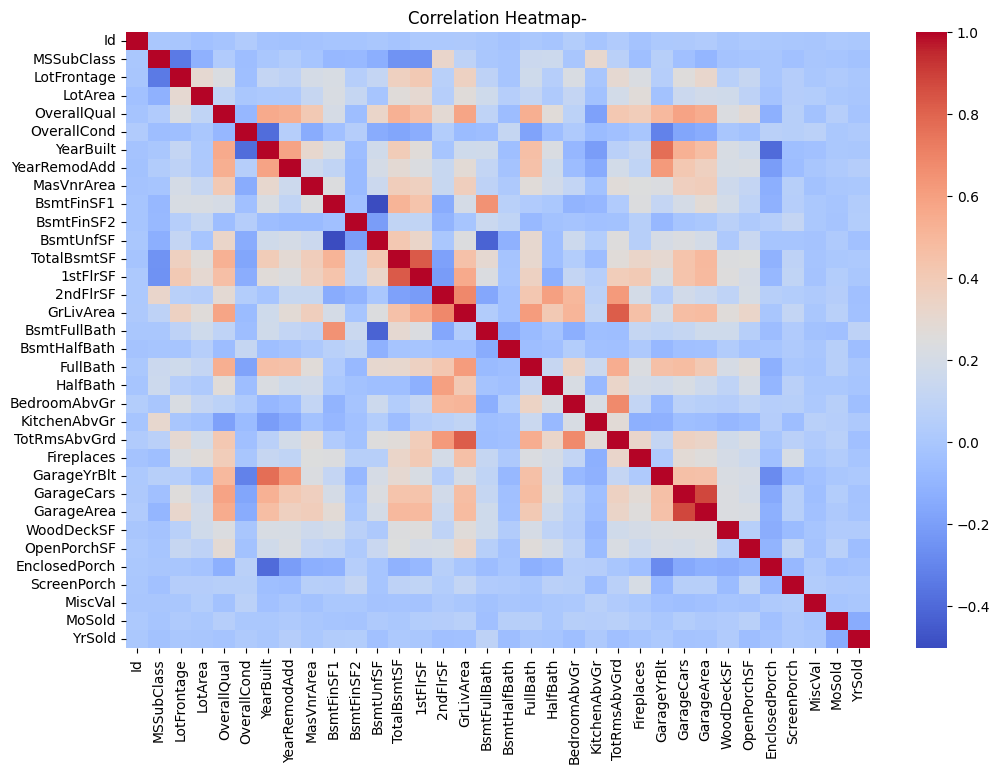

In [11]:
#Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap-")
plt.show()

**Step-8:** Mututal Information Regression

In [12]:
numerical_X_train = X_train.select_dtypes(include=['number'])

mi_scores = mutual_info_regression(numerical_X_train, y_train, discrete_features=False)
mi_df = pd.Series(mi_scores, index=numerical_X_train.columns)
mi_df = mi_df.sort_values(ascending=False)


low_importance = mi_df[mi_df < 0.01].index.tolist()

print(low_importance)

X_train = X_train.drop(columns=low_importance,axis=1)
X_test = X_test.drop(columns=low_importance, axis =1)

['BsmtHalfBath', 'Id', 'BsmtFinSF2', 'MiscVal', 'MoSold']


In [13]:
#Chi Square cannot be applied since the output feature is numerical

In [14]:
from sklearn.feature_selection import f_regression
import pandas as pd

# 1. Select numerical features
X_num = X_train.select_dtypes(include='number')

# 2. Compute F-statistic and p-values
f_scores, p_values = f_regression(X_num, y_train)

# 3. Wrap into a DataFrame for better understanding
anova_df = pd.DataFrame({
    'F_Score': f_scores,
    'P_Value': p_values
}, index=X_num.columns)

# 4. Sort by F-score (descending)
anova_df = anova_df.sort_values(by='F_Score', ascending=False)

# 5. Optional: remove features with weak relationship (e.g., p-value > 0.05)
insignificant_features = anova_df[anova_df['P_Value'] > 0.05].index.tolist()

print("Dropping features with weak linear relationship:", insignificant_features)

# 6. Drop those from train and test
X_train = X_train.drop(columns=insignificant_features)
X_test = X_test.drop(columns=insignificant_features)


Dropping features with weak linear relationship: ['YrSold']


# Feature Extraction 

**Wrapper Methods**

**Sequential Forward Selection**

In [15]:
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align columns (important after encoding train/test separately)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1)
X_test_encoded.fillna(0, inplace=True)

# Forward Selection
sfs1 = SFS(RandomForestRegressor(n_jobs=4, random_state=42),
           k_features=5,
           forward=True,
           floating=False,
           verbose=2,
           scoring='r2',
           cv=3)

sfs1 = sfs1.fit(X_train_encoded, y_train)

print('Best R² score: %.4f' % sfs1.k_score_)
print('Best subset (indices):', sfs1.k_feature_idx_)
print('Best subset (names):', sfs1.k_feature_names_)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   23.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:  1.8min finished

[2025-08-20 08:42:29] Features: 1/5 -- score: 0.6641935561824832[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   22.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done 203 out of 203 | elapsed:  1.9min finished

[2025-08-20 08:44:24] Features: 2/5 -- score: 0.7177154014991718[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   24.9s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done 202 out of 202 | elapsed:  2.0min finished

[2025-08-20 08:46:26] Features: 3/5 -- score: 0.7916745463968132[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   25.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:  2.1min finished

[2025-08-20 08:48:33] Features: 4/5 

Best R² score: 0.8447
Best subset (indices): (2, 3, 5, 8, 13)
Best subset (names): ('LotArea', 'OverallQual', 'YearBuilt', 'BsmtFinSF1', 'GrLivArea')


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.2min finished

[2025-08-20 08:50:45] Features: 5/5 -- score: 0.8446628667239692

In [ ]:
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align columns (important after encoding train/test separately)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1)
X_test_encoded.fillna(0, inplace=True)

# Forward Selection
sfs1 = SFS(RandomForestRegressor(n_jobs=4, random_state=42),
           k_features=5,
           forward=False,
           floating=False,
           verbose=2,
           scoring='r2',
           cv=3)

sfs1 = sfs1.fit(X_train_encoded, y_train)

print('Best R² score: %.4f' % sfs1.k_score_)
print('Best subset (indices):', sfs1.k_feature_idx_)
print('Best subset (names):', sfs1.k_feature_names_)

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.linear_model import LinearRegression

# Create regression model
lr = LinearRegression()

# Create EFS object
efs = EFS(estimator=lr,        
          min_features=1,      
          max_features=4,      
          scoring='r2',        # Use R² for regression
          cv=5)                

# Train EFS
efs = efs.fit(X_data, y_data)

# Print results
print('Best R² score: %.4f' % efs.best_score_) 
print('Best subset (indices):', efs.best_idx_)       
print('Best subset (corresponding names):', efs.best_feature_names_)

# Training Model with Linear Regression

**Preprocessing the Data converting the categorical variable using one hot encoding and using the pipeline**

In [21]:
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LinearRegression())
])

**Training the Model**

In [22]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

**Basic Evaluation Metrics**

In [25]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R² Score: {r2:.4f}')

MSE: 979290771.27
RMSE: 31293.62
MAE: 20180.67
R² Score: 0.8723


**Actual vs Predicted Plot**

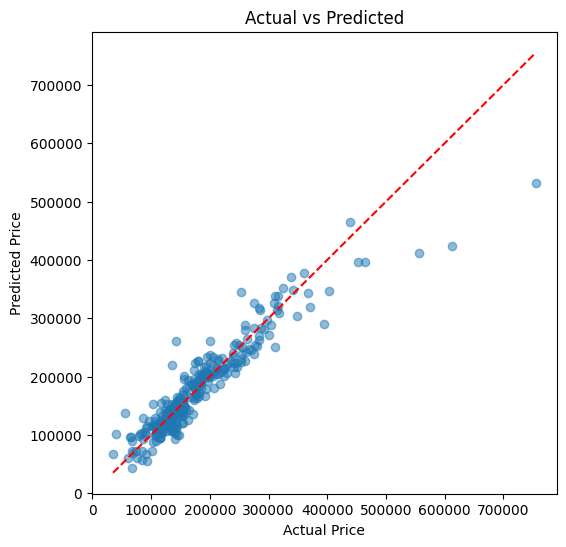

In [27]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted")
plt.show()

**Intercept and Slope Details**

In [32]:
model = pipeline.named_steps['model']
preprocessor = pipeline.named_steps['preprocessing']

intercept = model.intercept_
coefficients = mode`l.coef_
feature_names = preprocessor.get_feature_names_out()

for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef:.4f}")

print(f"\nIntercept: {intercept:.4f}")


cat__MSZoning_C (all): -4010.6757
cat__MSZoning_FV: 5147.4567
cat__MSZoning_RH: 1299.0634
cat__MSZoning_RL: 2999.2713
cat__MSZoning_RM: -5435.1157
cat__LotShape_IR1: -34.9538
cat__LotShape_IR2: 12331.3655
cat__LotShape_IR3: -13270.5333
cat__LotShape_Reg: 974.1216
cat__LandContour_Bnk: -20401.8170
cat__LandContour_HLS: 15904.7062
cat__LandContour_Low: 275.9702
cat__LandContour_Lvl: 4221.1406
cat__LotConfig_Corner: 2884.8484
cat__LotConfig_CulDSac: 11012.5658
cat__LotConfig_FR2: -10059.3249
cat__LotConfig_FR3: -3079.5576
cat__LotConfig_Inside: -758.5317
cat__LandSlope_Gtl: -3214.7510
cat__LandSlope_Mod: 5009.7082
cat__LandSlope_Sev: -1794.9572
cat__Neighborhood_Blmngtn: -9920.1905
cat__Neighborhood_Blueste: -622.9089
cat__Neighborhood_BrDale: 2822.9451
cat__Neighborhood_BrkSide: 5901.5835
cat__Neighborhood_ClearCr: -2251.3186
cat__Neighborhood_CollgCr: -7596.5728
cat__Neighborhood_Crawfor: 15659.3762
cat__Neighborhood_Edwards: -17910.0247
cat__Neighborhood_Gilbert: -12961.2887
cat__Neigh